# ROC analysis
This could allow us to ask whether activity in an area allows an ideal observer to detect stimulus presence/absence and how well it predicts subsequent behavioural choice.

There are 2 things in this notebook:
* simple ROC analysis that uses the mean over the whole population as decision variable for each trial (1 data point per trial)
* classifier that weights mean post-stimulus mean of each cell (n cells data points per trial), then ROC analysis to evaluate the performance of this classifier

In [105]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
#generic imports
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.extend(['..','../..'])
import pandas as pd
import numpy.random as random

In [229]:
# stats
from scipy import stats
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle

In [108]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# 1. ROC with decision variable as population mean

In [305]:
# Generate samples from two different distributions
#imagine there are 100 cells and 1000 recording frames from each cell for each trial type
A = np.zeros((100,1000))
B = np.zeros((100,1000))
for row in range(A.shape[0]):
    A[row,:] = np.random.normal(2,10,1000)
for row in range(B.shape[0]):
    B[row,:] = np.random.normal(2.23,7,1000)

In [298]:
# we need to split the samples from each cell into 20 trials of length 50 frames
# when we do this for real, the data must be aligned with stimulus timings to determine the start of each trial
trialsA = np.split(A,20,axis=1) 
trialsB = np.split(B,20,axis=1)
print('number of trials = {}, shape of data for each trial = {}'.format(len(trials),trials[0].shape))

number of trials = 20, shape of data for each trial = (100, 50)


In [299]:
all_trials = np.concatenate((trialsA,trialsB),axis=0)
len(all_trials)

40

In [300]:
labels = np.zeros((40))
labels[20:40] = 1

In [301]:
# ddcalculate mean response for each trial, for each cell
mean_dff_cell = np.mean(all_trials,axis=2)
# calculate mean response over the population for each trial
mean_dff_trial = np.mean(mean_dff_cell, axis = 1)

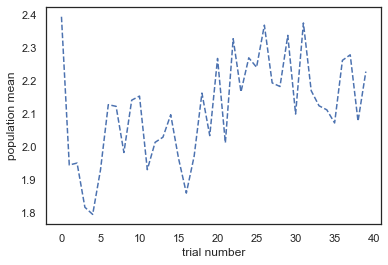

In [302]:
plt.plot(mean_dff_trial,'--')
plt.xlabel('trial number')
plt.ylabel('population mean')
plt.show()

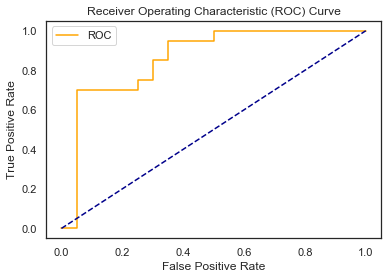

AUC: 0.86


In [303]:
# make ROC curve using skikit learn package
fpr, tpr, thresholds = roc_curve(labels, mean_dff_trial)
plot_roc_curve(fpr, tpr)
auc = roc_auc_score(labels, mean_dff_trial)
print('AUC: %.2f' % auc)

As predicted, the classification performance is around chance level for this data: this is because there were not really any non-stimulus trials and labels were generated randomly.

Using the average population dff is quite a crude approach, and discards information about the differences between the responses of individual cells.

We could now make a linear classifier that weights the dff of each individual cell to make the classification, and repeat the ROC analysis using the output of this model.

Data needs to look like:
n cells x n trials (matrix)
Weight matrix needs to looks like:
n cells x 1 

We could try SVM or logistic regression... this uses random forest atm

## Example ROC
### with randomly generated data and random forest classifier
https://stackabuse.com/understanding-roc-curves-with-python/

### Generate sample data to test idea
e.g. 1000 trials, 2 class labels  (no stim/stim), 20 cells per trial

In [304]:
# Generate a random n-class classification problem
data_X, class_label = make_classification(n_samples=1000, n_classes=2, weights=[1,1], random_state=1)
print(data_X.shape, class_label.shape)

(1000, 20) (1000,)


class_label contains the trial type label (0 or 1 = no stim or stim) (=n trials x 1 column vector)

data_X contains 1000 trial datapoints for 20 cells (=n trials x n cells)

Each data point in a trial is some summary statistic for an indiviual cell's response: e.g. average dff in some time window post-stimulus.

### Split data into train and test sets
In this example, we'll use 75% of the data for training, and save 25% of the data for testing the classifier.

In [12]:
trainX, testX, trainy, testy = train_test_split(data_X, class_label, test_size=0.3, random_state=1)

### Fit a classifier on the train data
many classifiers are available in the skikit-learn package https://scikit-learn.org/

In [13]:
model = RandomForestClassifier()
model.fit(trainX, trainy)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Predict probabilities for the test data.

In [14]:
probs = model.predict_proba(testX)

Keep Probabilities of the positive class only:

In [15]:
probs = probs[:, 1]

Compute the AUC Score. (area under curve for ROC analysis.... if 0.5, classifier is picking randomly. as 0.5---->1 classifier is better

In [16]:
auc = roc_auc_score(testy, probs)
print('AUC: %.2f' % auc)

AUC: 0.95


Make ROC curve using test dataset:

In [17]:
fpr, tpr, thresholds = roc_curve(testy, probs)

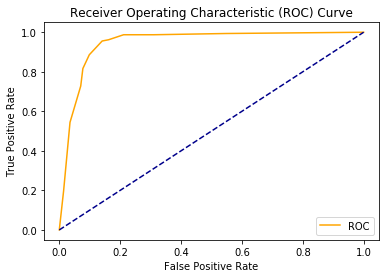

In [21]:
plot_roc_curve(fpr, tpr)

## example logistic regression classifier with SGD optimisation

In [22]:
from sklearn import linear_model

In [23]:
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3,loss='log')
clf.fit(trainX, trainy)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
probs = clf.predict_proba(testX)

In [25]:
probs = probs[:, 1]

In [26]:
fpr, tpr, thresholds = roc_curve(testy, probs)

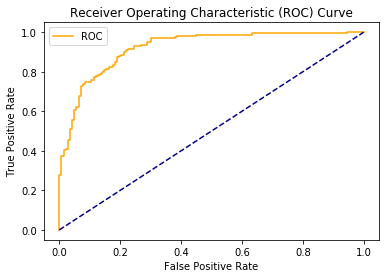

In [27]:
plot_roc_curve(fpr, tpr)

In [28]:
auc = roc_auc_score(testy, probs)
print('AUC: %.2f' % auc)

AUC: 0.92
